# stormchasers - Stlr features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 43 # stormchasers
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(2533, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533 entries, 0 to 2532
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            2533 non-null   int64  
 1   dimCustomerMasterId     2533 non-null   int64  
 2   customerNumber          2533 non-null   object 
 3   year                    2533 non-null   int64  
 4   productGrouping         2533 non-null   object 
 5   totalSpent              2533 non-null   float64
 6   recentDate              2533 non-null   object 
 7   attendancePercent       2533 non-null   float64
 8   renewedBeforeDays       2533 non-null   int64  
 9   isBuyer                 2533 non-null   object 
 10  source_tenure           2533 non-null   int64  
 11  tenure                  2533 non-null   int64  
 12  distToVenue             2533 non-null   float64
 13  totalGames              2533 non-null   int64  
 14  recency                 2533 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (1828, 13)
Unseen Data For Predictions: (322, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7250,0.7922,0.7515,0.7340,0.7417,0.4477,0.4492,0.2660
lr,Logistic Regression,0.7186,0.7822,0.6879,0.7588,0.7195,0.4384,0.4427,0.3060


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6923,0.7253,0.7561,0.6889,0.7209,0.3797,0.3818
1,0.7500,0.7919,0.7805,0.7529,0.7665,0.4977,0.4981
2,0.7628,0.8420,0.7195,0.8082,0.7613,0.5272,0.5307
3,0.7161,0.8262,0.7284,0.7284,0.7284,0.4311,0.4311
4,0.7806,0.8412,0.8395,0.7640,0.8000,0.5583,0.5614
5,0.6968,0.7908,0.6790,0.7237,0.7006,0.3941,0.3949
6,0.7226,0.8034,0.7805,0.7191,0.7485,0.4403,0.4422
7,0.7484,0.8224,0.7561,0.7654,0.7607,0.4955,0.4955
8,0.7161,0.7917,0.7927,0.7065,0.7471,0.4260,0.4297
9,0.6645,0.6872,0.6829,0.6829,0.6829,0.3268,0.3268


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(383, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
2150,43,321077826,323791,2021,Full Season,1574.44,2021-09-26,0.261438,41,TRUE,...,0,0,0.0,1,132,0,1,1,0.1836,0.8164
2151,43,321088248,322217,2021,Full Season,9428.88,2021-09-04,0.163333,40,TRUE,...,0,0,0.0,1,132,0,1,1,0.0307,0.9693
2152,43,351596640,319433,2021,Full Season,4657.60,2021-09-18,0.260000,41,TRUE,...,0,0,0.0,1,132,0,1,1,0.0823,0.9177
2153,43,351964138,319377,2021,Full Season,2787.20,2021-09-16,0.166667,40,TRUE,...,0,0,0.0,1,132,0,0,1,0.0062,0.9938
2154,43,352003352,324784,2021,Full Season,8457.28,2021-09-26,0.411864,40,TRUE,...,0,0,0.0,1,132,0,1,1,0.0270,0.9730


In [11]:
new_predictions["Label"].value_counts()

1    222
0    161
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.8, 1.0]       148
(-0.001, 0.2]     78
(0.2, 0.4]        59
(0.6, 0.8]        52
(0.4, 0.6]        46
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

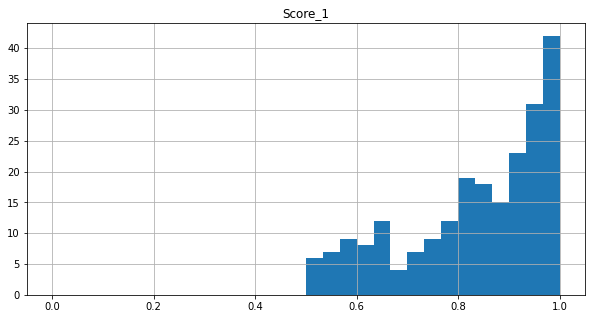

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

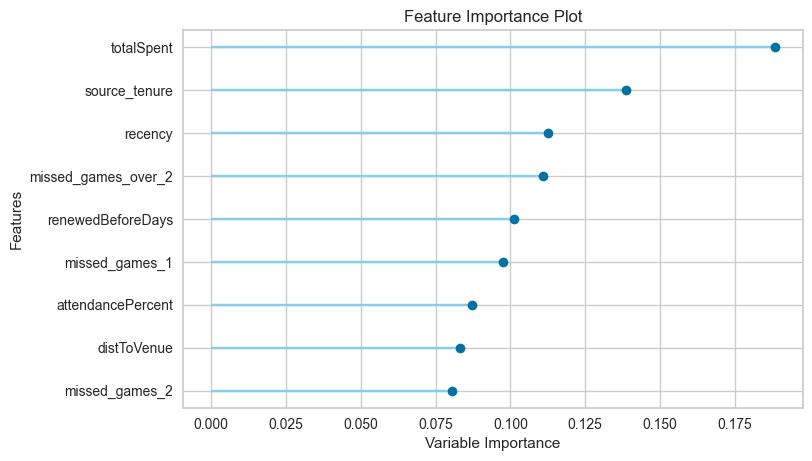

In [14]:
plot_model(best_model, plot='feature')

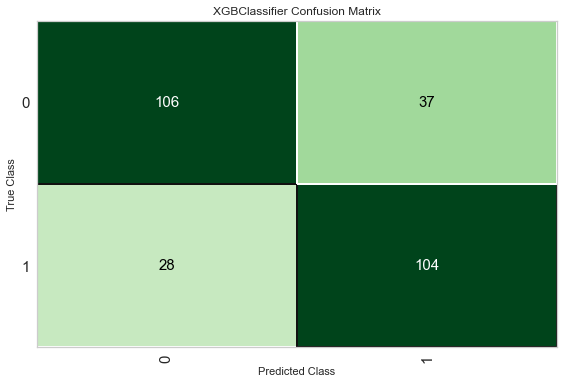

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

* the distribution doesn't look normal
* The ticketing data are in the top 3 feature importance
* The model makes more predictions of customers who won't buy
* The accuracy and the AUC decreased compared to using Full Season product

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?